Dimensionality Reduction via Principal Component Analysis (PCA)
================================================================

To understand PCA, check out the slides that accompany this code sample at [bitly.com/adi-pca-slides](http://bitly.com/adi-pca-slides).

Example 1: Point cloud
======================

Setup
-----
We'll be using [PCA from scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), a commonly used machine learning library in Python.

You will need to install some dependencies first if you haven't already. On Linux or Mac, you can run

```
sudo easy_install pip
```

to get a Python package manager called pip. Then run

```
pip install -U numpy
pip install -U scipy
pip install -U scikit-learn
```

to get scikit-learn.

In [3]:
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # 3D Plotting
from scipy import stats
import ipywidgets                         # interactions

%matplotlib inline

Create data
-----------
Now we will create a pathological case dataset to really demonstrate the use of PCA. Let's create a point cloud which is very flat in one direction. This way we can show that PCA "discards it" to reduce dimensionality since it doesn't contribute much information.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


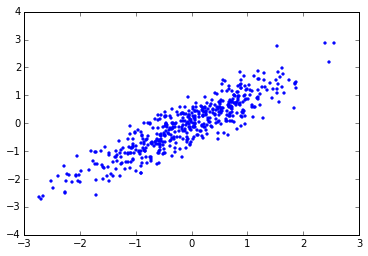

In [4]:
np.random.seed(4) # Reproducible results

mean = np.zeros(2)
cov = [[1, 0.9],
       [0.9, 1]]

data = np.random.multivariate_normal(mean, cov, size=500)
xs = data[:, 0]
ys = data[:, 1]

plt.scatter(xs, ys, marker=".", color="blue")

As you can see, most of the variation is in just one direction. We can formalize this intuition by using PCA to draw out the appropriate axes:

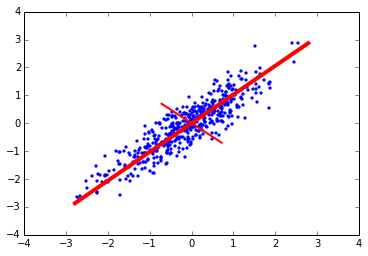

In [5]:
pca = PCA(n_components=2)
pca.fit(data)

axis1 = pca.components_[0]     # axis of most variation
axis2 = pca.components_[1]     # axis of second-most variation

plt.scatter(xs, ys, marker='.', color="blue")

plt.plot(axis1[0] * np.arange(-4, 5), axis1[1] * np.arange(-4, 5), linewidth=4,
         color="red")
plt.plot(axis2[0] * np.arange(-1, 2), axis2[1] * np.arange(-1, 2), linewidth=2, 
         color="red")

The two red lines define our new informative axis. As you can see, most of the information is stored in how far along the thicker red line the points are.

PCA doesn't just work for two dimensions. We could do it for large dimensional data. Here's a visualization with three dimensions:

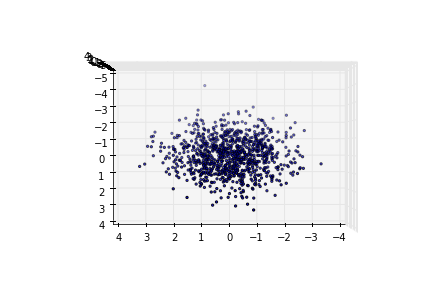

In [6]:
from ipywidgets import interact
mean = np.zeros(3)
cov = [[1, 0, 0],
       [0, 1, 0.9],
       [0, 0.9, 1]]

data = np.random.multivariate_normal(mean, cov, 1000)
xs = data[:, 0]
ys = data[:, 1]
zs = data[:, 2]

figure1 = plt.figure()
ax1 = Axes3D(figure1)
ax1.scatter(xs, ys, zs, marker='.')
plt.close(figure1)  # prevent double-display with interact

# You must be running the Jupyter notebook for interactions to work.
# It will just be a static image when viewed on GitHub or Nbviewer

@interact(elev=(0, 180), azim=(0, 180))
def plot_point_cloud(elev, azim):
    ax1.view_init(elev=elev, azim=azim)
    return figure1

In [7]:
pca = PCA(n_components=2)
pca.fit(data)

axis1 = pca.components_[0]
axis2 = pca.components_[1]

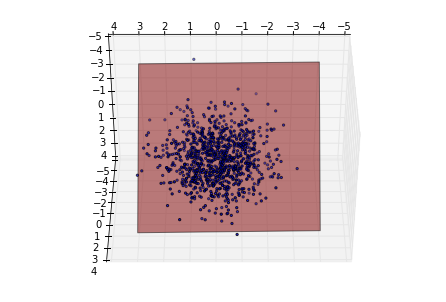

In [8]:
a, b, c = np.cross(axis1, axis2)

# By definition of cross product, <a, b, c> is orthogonal to the plane
# spanned by axis1 and axis2 through (0, 0, 0). The plane's equation is thus:
#      ax + by + cz = 0
# or   z = -(ax + by) / c
xx, yy = np.meshgrid(np.arange(-4, 4), np.arange(-4, 4))
zz = -(a * xx + b * yy) / c

figure2 = plt.figure()
ax2 = Axes3D(figure2)
ax2.plot_surface(xx, yy, zz, color="red", alpha=0.5)
ax2.scatter(xs, ys, zs, marker='.')
plt.close(figure2)

@interact(elev=(0, 180), azim=(0, 180))
def plot_point_cloud(elev, azim):
    ax2.view_init(elev=elev, azim=azim)
    return figure2

Example 2: Eigenfaces
=====================

Summary
-------
We'll be using an old dataset of creepy grayscale faces from AT&T called the [Olivetti Faces](http://scikit-learn.org/stable/datasets/olivetti_faces.html). Images of human faces are really complex. If we want to do facial recognition, we need to simplify them first. PCA is a great way to capture the distinctive features of a person's face that might help us in classifying them. So in this example, we're going to extract and plot only the principal components from the faces. Be warned, the results look a bit spooky.

Dataset consists of 400 faces
Extracting the top 6 components


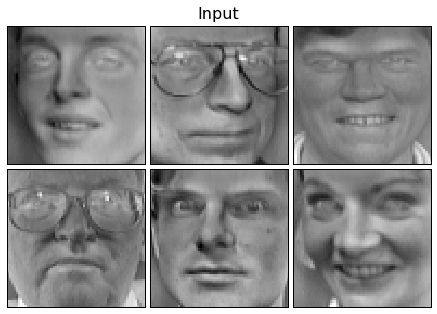

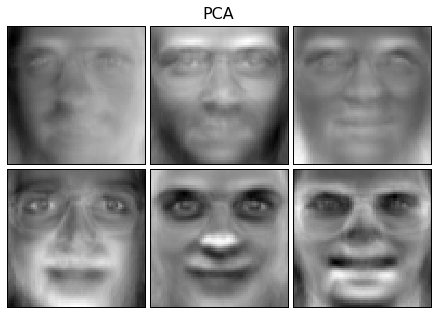

In [9]:
from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition

# Load faces data
faces = fetch_olivetti_faces(shuffle=True, random_state=RandomState(1)).data
n_samples, n_features = faces.shape

# Center the faces
faces_centered = faces - faces.mean(axis=0)
faces_centered -= faces_centered.mean(axis=1) \
                                .reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images, n_col=3, n_row=2):
    """
    Helper function to plot images.
    """
    image_shape = (64, 64)

    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
n_components = 6

# Plot a sample of the input data
plot_gallery("Input", faces_centered[:n_components])

# Apply PCA and plot results
print("Extracting the top %d components" % (n_components))
data = faces_centered
# We use a variant of PCA called Randomized PCA for efficiency. It uses stochastic SVD.
estimator = decomposition.RandomizedPCA(n_components=n_components, whiten=True)
estimator.fit(data)
plot_gallery('PCA', estimator.components_[:n_components])

plt.show()
